In [0]:
!rm -dr ~/.kaggle
!pip install -U -q kaggle

!mkdir -p ~/.kaggle
from google.colab import files

In [0]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dhiadardour","key":"b02370aaefadc98ad906cb293924adb6"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c ashrae-energy-prediction

 96% 115M/120M [00:00<00:00, 113MB/s]  
100% 120M/120M [00:00<00:00, 145MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 179MB/s]
 94% 83.0M/88.4M [00:02<00:00, 29.1MB/s]
100% 88.4M/88.4M [00:02<00:00, 42.7MB/s]
 92% 153M/167M [00:01<00:00, 126MB/s]
100% 167M/167M [00:01<00:00, 123MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 14.5MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 167MB/s]


In [0]:
!unzip weather_train.csv.zip
!unzip weather_test.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
!unzip sample_submission.csv.zip

Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [0]:
def read_and_interpret_data(filename):
    path = "/content"
    df = pd.read_csv('{0}/{1}'.format(path,filename))
    print("~~~~~~Shape of the data~~~~~~ : ",df.shape)
    print("~~~~~~Columns and their datatype~~~~~~ : ")
    print(df.info())
    print("~~~~~~Quick Look at the data~~~~~~ : ")
    print(df.head())
    print("~~~~~~Description of the data~~~~~~ : ")
    print(df.describe())
    print("~~~~~~NAs present in the data~~~~~~ : ")
    print(df.isna().sum())
    if 'timestamp' in df.columns: 
        df['timestamp'] = pd.to_datetime(df['timestamp'],format = "%Y-%m-%d %H:%M:%S")
        print("~~~~~~Year of the data~~~~~~ :")
        print(df.timestamp.dt.year.unique())
    return df

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# *Train Data *

In [0]:
df_train = read_and_interpret_data('train.csv')

~~~~~~Shape of the data~~~~~~ :  (20216100, 4)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
None
~~~~~~Quick Look at the data~~~~~~ : 
   building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0
~~~~~~Description of the data~~~~~~ : 
        building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   2.117121e+03
std    4.269133e+02  9.309921e-01   1.532356e+05
min    0.000

In [0]:
df_train['month'] = df_train['timestamp'].dt.month
df_train['dayofweek'] = df_train['timestamp'].dt.dayofweek
df_train['hourofday'] = df_train['timestamp'].dt.hour

In [0]:
df_train.shape

(20216100, 7)

In [0]:
df_train.tail()

,building_id,meter,timestamp,meter_reading,month,dayofweek,hourofday
20216095,1444,0,2016-12-31 23:00:00,8.750,12,5,23
20216096,1445,0,2016-12-31 23:00:00,4.825,12,5,23
20216097,1446,0,2016-12-31 23:00:00,0.000,12,5,23
20216098,1447,0,2016-12-31 23:00:00,159.575,12,5,23
20216099,1448,0,2016-12-31 23:00:00,2.850,12,5,23


In [0]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 347.03 Mb (67.9% reduction)


### *building_metadata*

In [0]:
df_building_metadata = read_and_interpret_data('building_metadata.csv')

~~~~~~Shape of the data~~~~~~ :  (1449, 6)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB
None
~~~~~~Quick Look at the data~~~~~~ : 
   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN
~~~~~~Description of the data~~~~~~ : 
       

In [0]:
def plot_hist(df,var_name):
    plt.figure(figsize=(14,6))
    plt.hist(df[var_name],bins = 50)
    plt.title(f"Histogram - {var_name}")
    plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


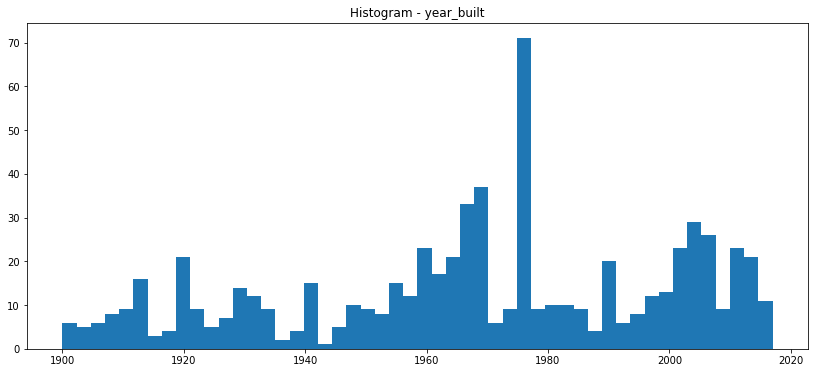

In [0]:
plot_hist(df_building_metadata,'year_built')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


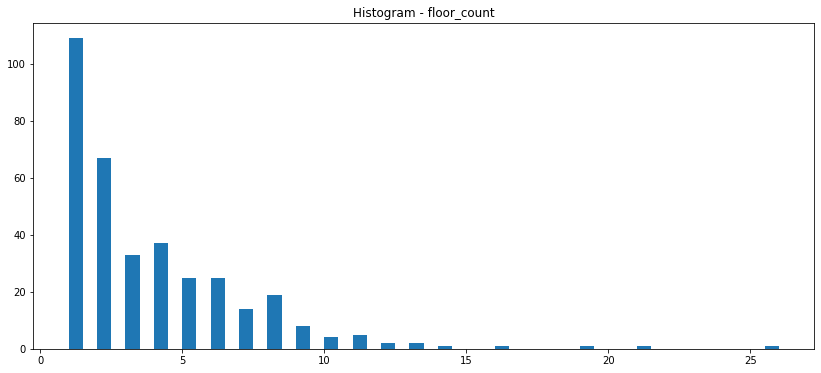

In [0]:
plot_hist(df_building_metadata,'floor_count')

In [0]:
(df_building_metadata.year_built.isna().sum()/df_building_metadata.shape[0])*100

53.41614906832298

In [0]:
df_building_metadata['year_built'].value_counts()

1976.0    55
1966.0    23
1968.0    18
1919.0    17
1964.0    15
          ..
1934.0     1
1936.0     1
1926.0     1
2017.0     1
1947.0     1
Name: year_built, Length: 116, dtype: int64

In [0]:
# Making a list of mode years
mode_yr1,mode_yr2 = list(range(1960,1975)),  list(range(2000,2010))
mode_years = mode_yr1 + mode_yr2

In [0]:
# Replacing NAs by chooosing randomly from the mode years
import random
random.seed(123)

nans = df_building_metadata['year_built'].isna()
length = sum(nans)
replacement = random.choices(mode_years, k=length)
df_building_metadata.loc[nans,'year_built'] = replacement

In [0]:
df_building_metadata.year_built.isna().sum()

0

In [0]:
df_building_metadata['year_built'].value_counts()

1968.0    61
1976.0    55
1964.0    53
1970.0    51
2001.0    51
          ..
1944.0     1
1934.0     1
1926.0     1
2017.0     1
1947.0     1
Name: year_built, Length: 116, dtype: int64

In [0]:
(df_building_metadata.floor_count.isna().sum()/df_building_metadata.shape[0])*100

75.50034506556246

In [0]:
df_building_metadata['floor_count'].value_counts()

1.0     109
2.0      67
4.0      37
3.0      33
5.0      25
6.0      25
8.0      19
7.0      14
9.0       8
11.0      5
10.0      4
12.0      2
13.0      2
19.0      1
26.0      1
14.0      1
21.0      1
16.0      1
Name: floor_count, dtype: int64

In [0]:
import random
floor= df_building_metadata['floor_count'].unique()
nans = df_building_metadata['floor_count'].isna()
length = sum(nans)
print(length)
replacement = random.choices(floor, k=length)
df_building_metadata.loc[nans,'floor_count'] = replacement

0


In [0]:
df_building_metadata['floor_count'].value_counts()

1.0     184
2.0     133
4.0     119
3.0     111
6.0     108
5.0      97
8.0      92
10.0     85
9.0      84
7.0      78
14.0     77
12.0     73
11.0     72
15.0     71
13.0     61
26.0      1
16.0      1
21.0      1
19.0      1
Name: floor_count, dtype: int64

In [0]:
#df_building_metadata['floor_count'].fillna(1, inplace = True)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_building_metadata["primary_use"] = le.fit_transform(df_building_metadata["primary_use"])

In [0]:
df_building_metadata.primary_use.tail()

1444    1
1445    0
1446    1
1447    4
1448    6
Name: primary_use, dtype: int64

In [0]:
df_building_metadata = reduce_mem_usage(df_building_metadata)

Mem. usage decreased to  0.02 Mb (74.9% reduction)


# weather_train

In [0]:
df_weather_train = read_and_interpret_data('weather_train.csv')

~~~~~~Shape of the data~~~~~~ :  (139773, 9)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
None
~~~~~~Quick Look at the data~~~~~~ : 
   site_id            timestamp  ...  wind_direction  wind_speed
0        0  2016-01-01 00:00:00  ...             0.0         0.0
1        0  2016-01-01 01:00:00  ...            70.0         1.5
2        0  2016-01-01 02:00:00  ...             0.0         0.0
3        0  2016-01-01 03:00:

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


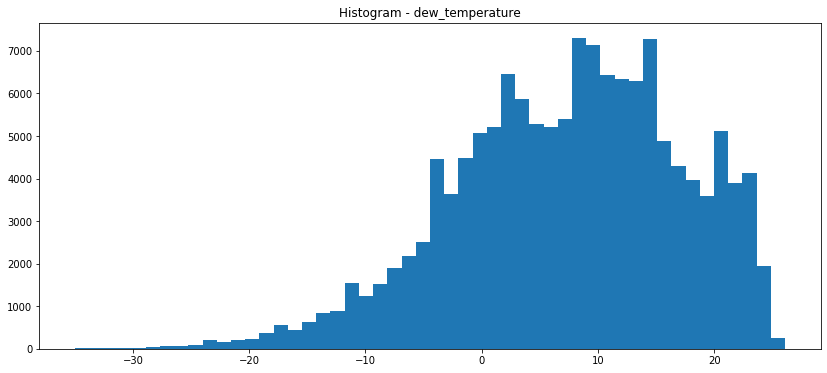

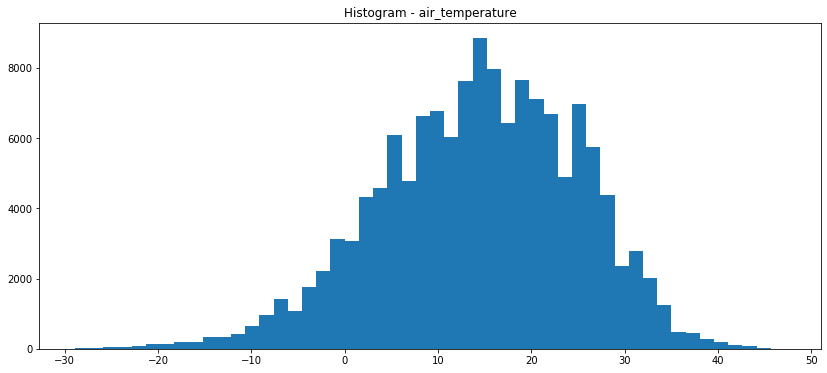

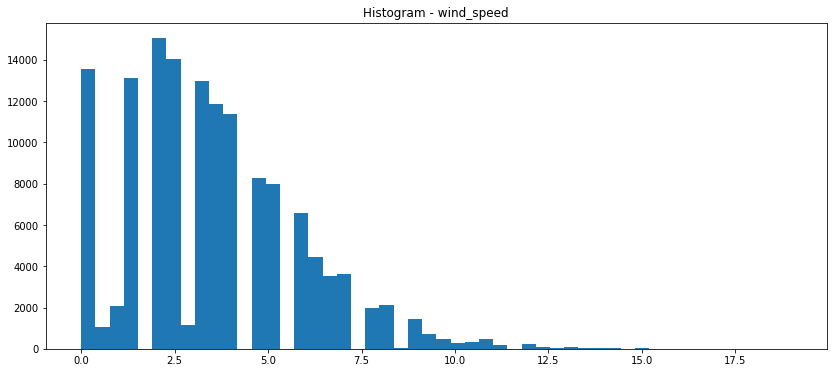

In [0]:
for var in ['dew_temperature','air_temperature','wind_speed']:
    plot_hist(df_weather_train,var)

In [0]:
import datetime
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = weather_df['timestamp'].min().to_pydatetime()
    end_date = weather_df['timestamp'].max().to_pydatetime()
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = np.array([(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)])

    missing_hours = []
    for site_id in range(16):
        
        site_tot_hrs = df_weather_train[df_weather_train['site_id'] == 1]['timestamp']
        site_hours = np.array([x.strftime(time_format) for x in site_tot_hrs])
#         site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    # AIR TEMPERATURE
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # CLOUD COVERAGE
    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
    weather_df.update(cloud_coverage_filler,overwrite=False)

    # DEW TEMPERATURE
    dew_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(dew_temperature_filler,overwrite=False)

    # SEA LEVEL PRESSURE
    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    # WIND DIRECTION
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    # WIND SPEED
    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # PRECIPITATION DEPTH
    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

def limit_dew_temp(air_temp, dew_temp):
    if dew_temp > air_temp:
        return air_temp
    else:
        return dew_temp

In [0]:
df_weather_train = fill_weather_dataset(df_weather_train)
df_weather_train['dew_temperature'] = df_weather_train.apply(lambda x: limit_dew_temp(x.air_temperature, x.dew_temperature), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [0]:
df_weather_train.head()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,timestamp,wind_direction,wind_speed
0,0,25.0,6.000000,20.0,-0.173913,1019.7,2016-01-01 00:00:00,0.0,0.0
1,0,24.4,4.285714,21.1,-1.000000,1020.2,2016-01-01 01:00:00,70.0,1.5
2,0,22.8,2.000000,21.1,0.000000,1020.2,2016-01-01 02:00:00,0.0,0.0
3,0,21.1,2.000000,20.6,0.000000,1020.1,2016-01-01 03:00:00,0.0,0.0
4,0,20.0,2.000000,20.0,-1.000000,1020.0,2016-01-01 04:00:00,250.0,2.6


In [0]:
df_weather_train.isna().sum()

site_id               0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
timestamp             0
wind_direction        0
wind_speed            0
dtype: int64

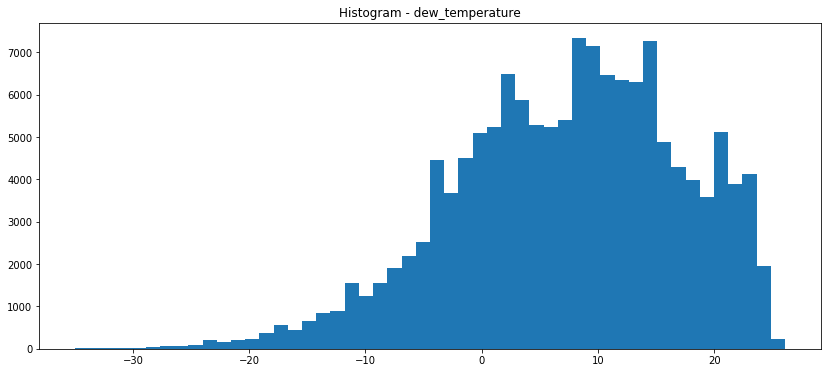

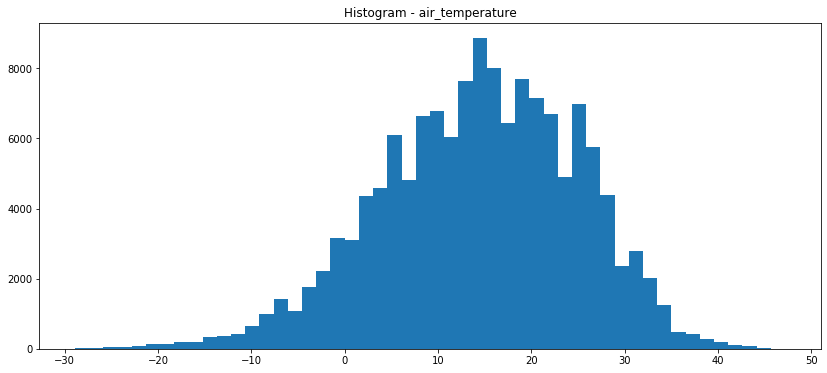

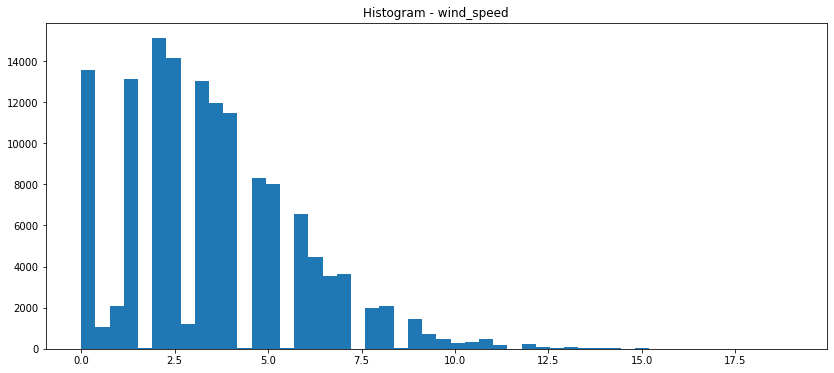

In [0]:
for var in ['dew_temperature','air_temperature','wind_speed']:
    plot_hist(df_weather_train,var)

In [0]:
df_weather_train = reduce_mem_usage(df_weather_train)

Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [0]:
train_df = pd.merge(df_train,df_building_metadata,on = 'building_id')
train_df.head()

,building_id,meter,timestamp,meter_reading,month,dayofweek,hourofday,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,1,4,0,0,0,7432,2008.0,9.0
1,0,0,2016-01-01 01:00:00,0.0,1,4,1,0,0,7432,2008.0,9.0
2,0,0,2016-01-01 02:00:00,0.0,1,4,2,0,0,7432,2008.0,9.0
3,0,0,2016-01-01 03:00:00,0.0,1,4,3,0,0,7432,2008.0,9.0
4,0,0,2016-01-01 04:00:00,0.0,1,4,4,0,0,7432,2008.0,9.0


In [0]:
train_df.shape

(20216100, 12)

In [0]:
df_weather_train['timestamp'] = pd.to_datetime(df_weather_train['timestamp'])
train_df = pd.merge(train_df,df_weather_train,on = ['site_id','timestamp'])

In [0]:
train_df.shape

(20170686, 19)

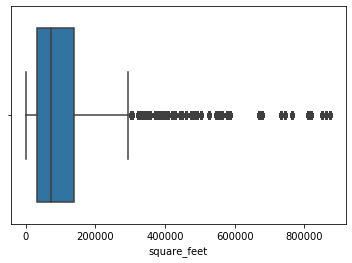

In [0]:
sns.boxplot(train_df['square_feet'])

In [0]:
train_df['square_feet'] =  np.log(train_df['square_feet'])

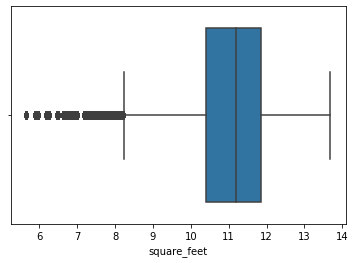

In [0]:
sns.boxplot(train_df['square_feet'])

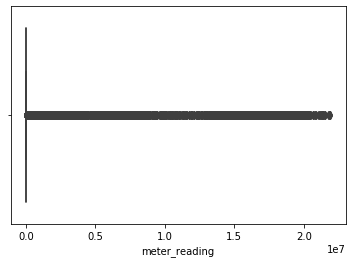

In [0]:
sns.boxplot(train_df['meter_reading'])

In [0]:
target = np.log1p(train_df["meter_reading"])

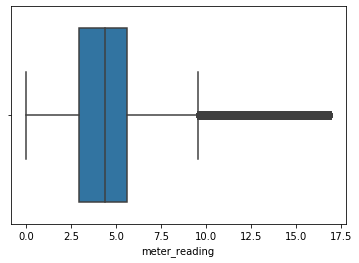

In [0]:
sns.boxplot(target)

In [0]:
features = train_df.drop('meter_reading', axis = 1)

In [0]:
features=features.drop("timestamp",axis = 1)

In [0]:
features.isna().sum()

building_id           0
meter                 0
month                 0
dayofweek             0
hourofday             0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [0]:
features.shape

(20170686, 17)

In [0]:
target.shape

(20170686,)

# Testing Data

In [0]:
df_test = read_and_interpret_data('test.csv')

~~~~~~Shape of the data~~~~~~ :  (41697600, 4)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB
None
~~~~~~Quick Look at the data~~~~~~ : 
   row_id  building_id  meter            timestamp
0       0            0      0  2017-01-01 00:00:00
1       1            1      0  2017-01-01 00:00:00
2       2            2      0  2017-01-01 00:00:00
3       3            3      0  2017-01-01 00:00:00
4       4            4      0  2017-01-01 00:00:00
~~~~~~Description of the data~~~~~~ : 
             row_id   building_id         meter
count  4.169760e+07  4.169760e+07  4.169760e+07
mean   2.084880e+07  8.075824e+02  6.642857e-01
std    1.203706e+07  4.297680e+02  9.278067e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.042440e+07  4.047500e+02 

In [0]:
df_test['month'] = df_test['timestamp'].dt.month
df_test['dayofweek'] = df_test['timestamp'].dt.dayofweek
df_test['hourofday'] = df_test['timestamp'].dt.hour

In [0]:
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 715.79 Mb (67.9% reduction)


In [0]:
df_weather_test = read_and_interpret_data('weather_test.csv')

~~~~~~Shape of the data~~~~~~ :  (277243, 9)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null int64
timestamp             277243 non-null object
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_hr     181655 non-null float64
sea_level_pressure    255978 non-null float64
wind_direction        264873 non-null float64
wind_speed            276783 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 19.0+ MB
None
~~~~~~Quick Look at the data~~~~~~ : 
   site_id            timestamp  ...  wind_direction  wind_speed
0        0  2017-01-01 00:00:00  ...           100.0         3.6
1        0  2017-01-01 01:00:00  ...           130.0         3.1
2        0  2017-01-01 02:00:00  ...           140.0         3.1
3        0  2017-01-01 03:

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


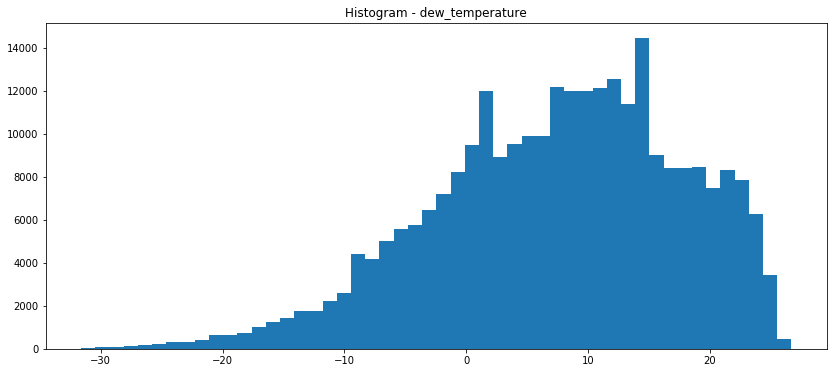

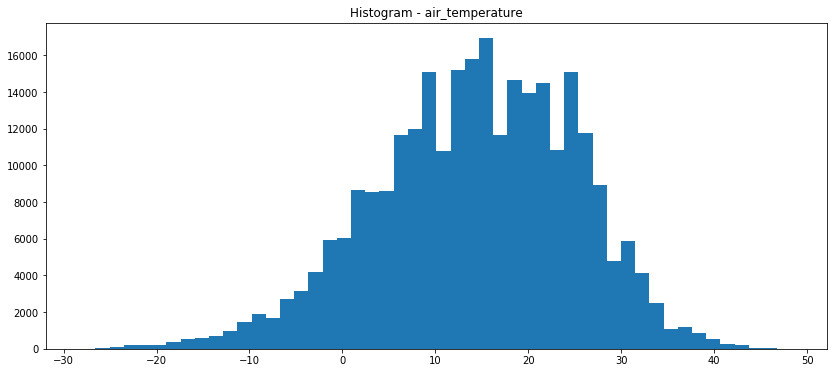

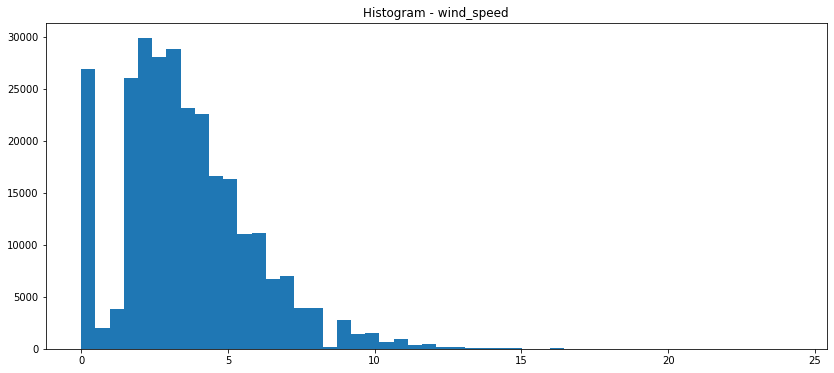

In [0]:
for var in ['dew_temperature','air_temperature','wind_speed']:
    plot_hist(df_weather_test,var)

In [0]:
df_weather_test.isna().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64

In [0]:
df_weather_test.fillna(df_weather_test.median(),inplace=True)
df_weather_test['dew_temperature'] = df_weather_test.apply(lambda x: limit_dew_temp(x.air_temperature, x.dew_temperature), axis=1)

In [0]:
df_weather_test.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [0]:
df_weather_test.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
277238,15,2018-12-31 19:00:00,3.3,2.0,1.7,0.0,1018.3,150.0,7.7
277239,15,2018-12-31 20:00:00,2.8,2.0,1.1,0.0,1017.8,140.0,5.1
277240,15,2018-12-31 21:00:00,2.8,2.0,1.7,-1.0,1017.2,140.0,6.2
277241,15,2018-12-31 22:00:00,2.8,2.0,2.2,8.0,1016.1,140.0,5.1
277242,15,2018-12-31 23:00:00,3.3,2.0,2.2,20.0,1014.7,140.0,5.1


In [0]:
df_weather_test = reduce_mem_usage(df_weather_test)

Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [0]:
test_df = pd.merge(df_test,df_building_metadata,on = 'building_id')

In [0]:
df_weather_test['timestamp'] = pd.to_datetime(df_weather_test['timestamp'])

In [0]:
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 1431.57 Mb (0.0% reduction)


In [0]:
test_df = pd.merge(test_df,df_weather_test,on = ['site_id','timestamp'],how='left')

In [0]:
row_ids = test_df['row_id']
test_df = test_df.drop(['timestamp','row_id'],axis = 1)

In [0]:
test_df["square_feet"] = np.log1p(test_df["square_feet"])

In [0]:
test_df.isna().sum()

building_id                0
meter                      0
month                      0
dayofweek                  0
hourofday                  0
site_id                    0
primary_use                0
square_feet                0
year_built                 0
floor_count                0
air_temperature       199029
cloud_coverage        199029
dew_temperature       199029
precip_depth_1_hr     199029
sea_level_pressure    199029
wind_direction        199029
wind_speed            199029
dtype: int64

In [0]:
test_df.fillna(test_df.median(),inplace=True)

In [0]:
test_df.tail()

,building_id,meter,month,dayofweek,hourofday,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
41697595,1448,0,11,2,10,15,6,11.432496,2001.0,9.0,16.703125,2.0,8.898438,0.0,1016.5,190.0,3.099609
41697596,1448,0,11,2,11,15,6,11.432496,2001.0,9.0,16.703125,2.0,8.898438,0.0,1016.5,190.0,3.099609
41697597,1448,0,5,2,5,15,6,11.432496,2001.0,9.0,16.703125,2.0,8.898438,0.0,1016.5,190.0,3.099609
41697598,1448,0,5,2,6,15,6,11.432496,2001.0,9.0,16.703125,2.0,8.898438,0.0,1016.5,190.0,3.099609
41697599,1448,0,5,2,7,15,6,11.432496,2001.0,9.0,16.703125,2.0,8.898438,0.0,1016.5,190.0,3.099609


In [0]:
features.columns

Index(['building_id', 'meter', 'month', 'dayofweek', 'hourofday', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [0]:
test_df.columns

Index(['building_id', 'meter', 'month', 'dayofweek', 'hourofday', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [0]:
submission=read_and_interpret_data("sample_submission.csv")

~~~~~~Shape of the data~~~~~~ :  (41697600, 2)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           int64
meter_reading    int64
dtypes: int64(2)
memory usage: 636.3 MB
None
~~~~~~Quick Look at the data~~~~~~ : 
   row_id  meter_reading
0       0              0
1       1              0
2       2              0
3       3              0
4       4              0
~~~~~~Description of the data~~~~~~ : 
             row_id  meter_reading
count  4.169760e+07     41697600.0
mean   2.084880e+07            0.0
std    1.203706e+07            0.0
min    0.000000e+00            0.0
25%    1.042440e+07            0.0
50%    2.084880e+07            0.0
75%    3.127320e+07            0.0
max    4.169760e+07            0.0
~~~~~~NAs present in the data~~~~~~ : 
row_id           0
meter_reading    0
dtype: int64


In [0]:
submission= reduce_mem_usage(submission)

Mem. usage decreased to 198.83 Mb (68.7% reduction)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K

In [0]:
features.shape

(20170686, 17)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

print(X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(5042672, 17) (15128014, 17) (5042672,) (15128014,)


In [0]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [0]:
def create_model(dense_layer_sizes, optimizer="adam", dropout=0.1, init='uniform', nbr_features=17, dense_nparams=256, lr=0.001):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(nbr_features,), kernel_initializer=init,)) 
    model.add(BatchNormalization())
    model.add(Dropout(dropout), )
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout), )
    model.add(Dense(1, activation='relu'))
    opt = Adam(lr)
    model.compile(loss='mse', optimizer=opt, metrics=[root_mean_squared_error])
    return model

In [0]:
model = create_model(dense_layer_sizes=[ 256,128, 64, 32], dropout=0.2, dense_nparams=512)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
hist = model.fit(X_train, y_train, epochs=32, batch_size=8192)

Train on 15128014 samples
Epoch 1/32
15128014/15128014 [==============================] - 408s 27us/sample - loss: 3.2113 - root_mean_squared_error: 1.7513
Epoch 2/32
15128014/15128014 [==============================] - 464s 31us/sample - loss: 2.0499 - root_mean_squared_error: 1.4311
Epoch 3/32
15128014/15128014 [==============================] - 412s 27us/sample - loss: 1.7875 - root_mean_squared_error: 1.3367
Epoch 4/32
15128014/15128014 [==============================] - 455s 30us/sample - loss: 1.6600 - root_mean_squared_error: 1.2882
Epoch 5/32
15128014/15128014 [==============================] - 406s 27us/sample - loss: 1.5833 - root_mean_squared_error: 1.2581
Epoch 6/32
15128014/15128014 [==============================] - 454s 30us/sample - loss: 1.5367 - root_mean_squared_error: 1.2395
Epoch 7/32
15128014/15128014 [==============================] - 410s 27us/sample - loss: 1.4995 - root_mean_squared_error: 1.2244
Epoch 8/32
15128014/15128014 [==============================] - 

In [0]:
y_pred = model.predict(test_df.values, batch_size=8192, verbose=1)

In [0]:
submission['meter_reading'] = np.log1p(submission['meter_reading'])
submission['meter_reading'] = np.expm1(y_pred)

In [0]:
csv = submission.to_csv('./my-submission.csv', index=False)

In [0]:
!kaggle competitions submit ashrae-energy-prediction -f my-submission.csv -m 'Final submission'